In [1]:
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt

import xarray as xr
import sys
sys.path.append('../dataset')
from data.common import  CreateListOfLinkfilesInSpan

In [2]:
def extractGPMtime(dataset, attrstr):
    t_str = dataset.attrs['gpm_time_'+attrstr]
    t_dt = datetime.datetime.strptime(t_str if len(t_str)==26 else t_str+'.000000', '%Y-%m-%d %H:%M:%S.%f')
    
    return(t_dt)

def extractGOEStime(dataset, attrstr, ind):
    t_str = dataset.attrs['goes_time_'+attrstr][ind]
    t_dt = datetime.datetime.strptime(t_str if len(t_str)==26 else t_str+'.000000', '%Y-%m-%d %H:%M:%S.%f')
    
    return(t_dt)

def midTime(t_in, t_out):
    mid = t_in + datetime.timedelta(seconds=(t_out-t_in).total_seconds()/2)
    return(mid)

def timeDiff(t2, t1):
    time_diff = (t2-t1).total_seconds()
    return(time_diff)

In [3]:
num_goes = 8

In [12]:
f = open('../path_to_data.txt', "r")
path_to_dataset = f.read()
f.close() 

In [15]:
data_loc = os.path.join(path_to_dataset,'origin/')
linkdirs = CreateListOfLinkfilesInSpan(17, 12, 21, 3)
parentdirs = [data_loc + linkdir + '/' for linkdir in linkdirs]

In [16]:
file_list = []
gpm_len = []
goes_len_mean = []
goes_len_std = []
max_time_diffs = []

for parentdir in parentdirs:
    print(parentdir)
    for path, subdir, files in os.walk(parentdir):
        for file in files:    
            if file.endswith('.nc'):
                file_list.append(os.path.join(path,file))
                dataset = xr.open_dataset(os.path.join(path,file))
                dataset.close()

                gpm_in = extractGPMtime(dataset, 'in')
                gpm_out = extractGPMtime(dataset, 'out')

                goes_ins = [extractGOEStime(dataset, 'in', i) for i in range(num_goes)]
                goes_outs = [extractGOEStime(dataset, 'out', i) for i in range(num_goes)]

                gpm_len.append(timeDiff(gpm_out,gpm_in))
                goes_diff = [timeDiff(goes_out,goes_in) for goes_in, goes_out in zip(goes_ins, goes_outs)]
                goes_len_mean.append(np.mean(goes_diff))
                goes_len_std.append(np.std(goes_diff))

                gpm_mid = midTime(gpm_in, gpm_out)
                goes_mids = [midTime(goes_in, goes_out) for goes_in, goes_out in zip(goes_ins, goes_outs)]

                time_diff = [timeDiff(gpm_mid, goes_mid) for goes_mid in goes_mids]
                maxabsind = np.argmax(np.abs(np.array(time_diff)))
                max_time_diffs.append(time_diff[maxabsind])


/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2017-12/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-01/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-02/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-03/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-04/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-05/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-06/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-07/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-08/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-09/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-10/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-11/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2018-12/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2019-01/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2019-02/
/home/ingrid/Dendrite/UserAreas/Ingrid/origin/linkfile2

In [6]:
print('number of samples: ', len(file_list))

number of samples:  9694


min 2.8583333166666667
max 3.978333333333333


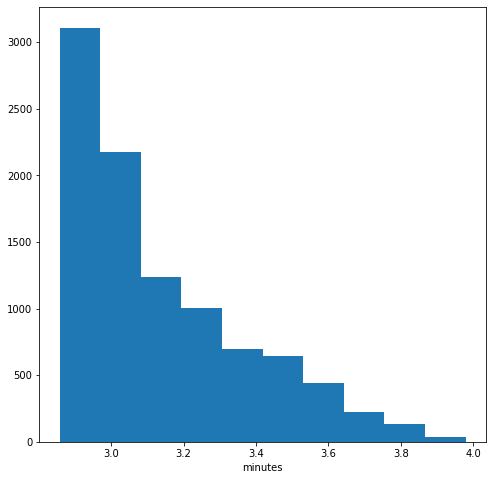

In [7]:
gpm_len_arr = np.array(gpm_len)/60
print('min', min(gpm_len_arr))
print('max', max(gpm_len_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(gpm_len_arr, bins=10)
ax.set_xlabel('minutes')
plt.show()

min 4.678541666666666
max 10.623333333333335


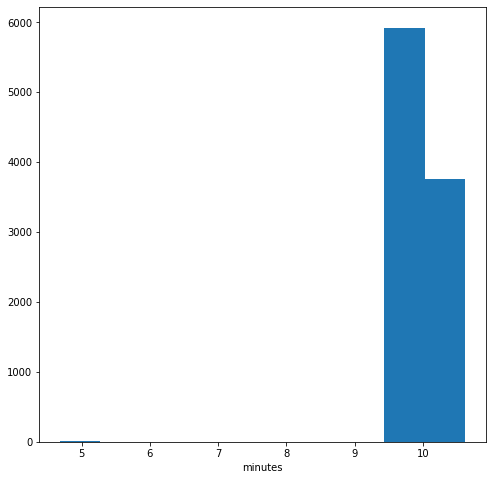

In [8]:
goes_len_arr = np.array(goes_len_mean)/60
print('min', min(goes_len_arr))
print('max', max(goes_len_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(goes_len_arr, bins=10)
ax.set_xlabel('minutes')
plt.show()

min 0.4330127018922193
max 0.5655473012932115


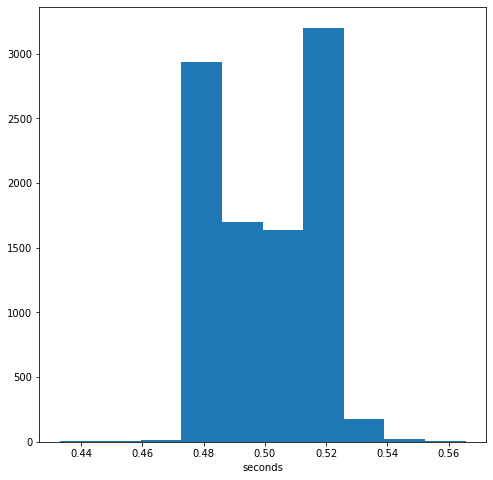

In [9]:
goes_len_std_arr = np.array(goes_len_std)
print('min', min(goes_len_std_arr))
print('max', max(goes_len_std_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(goes_len_std_arr, bins=10)
ax.set_xlabel('seconds')
plt.show()

[-9. -8. -7. -6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.
  9. 10.]
min -7.066050000000001
max 8.003616666666666


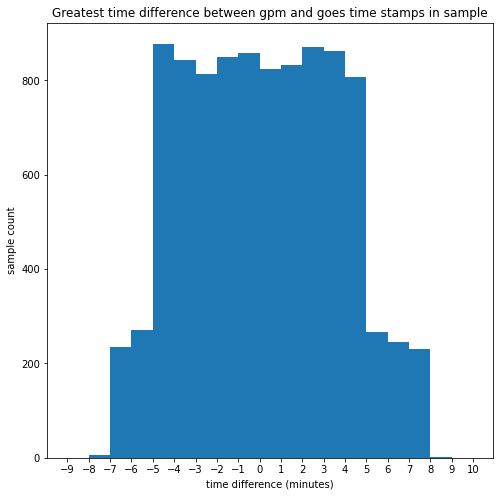

In [10]:
bins = np.linspace(-9,10,20)
print(bins)
max_time_diff_arr = np.array(max_time_diffs)/60
print('min', min(max_time_diff_arr))
print('max', max(max_time_diff_arr))
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(max_time_diff_arr, bins=bins)
ax.set_title('Greatest time difference between gpm and goes time stamps in sample')
ax.set_ylabel('sample count')
ax.set_xlabel('time difference (minutes)')
ax.set_xticks(bins)
plt.show()

In [11]:
inds = [(td < 5) and (td > -5) for td in max_time_diff_arr]
len(max_time_diff_arr[inds])

8440